In [1]:
import simulator.server as server
import simulator.workerhandler as wh
import topology_utils as tu

## Initialize components of our simulations ##

In [2]:
server1 = server.server()
workers = wh.workerhandler(num_genuine_workers=5, num_malicious_workers=1)
tm = tu.topology_manager()

## Define network topology ##

In [3]:
tm.connect_star(server1, workers.get_all_workers())

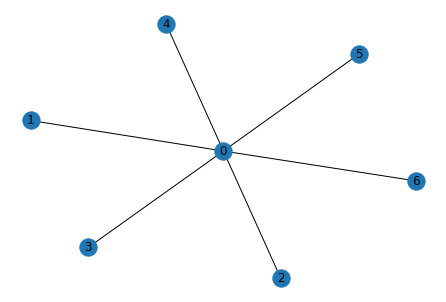

In [5]:
plot = tm.plot_topology()